In [25]:
'''
TEMAT 3. Cyfromania
a. Rozpoznawanie zestawu ręcznie pisanych cyfr
b. Ciąg n cyfr opartych o MNIST
c. typ zadania: klasyfikacja sekwencji znaków z możliwym wykorzystaniem
rekurencyjnych sieci neuronowych
d. wersja podstawowa: stała ilość cyfr
e. wersja zaawansowana: zmienna ilość cyfr na obrazie
f. ciekawe rozszerzenie: wykonywanie obliczeń pisanych ręcznie na kartce

'''

'\nTEMAT 3. Cyfromania\na. Rozpoznawanie zestawu ręcznie pisanych cyfr\nb. Ciąg n cyfr opartych o MNIST\nc. typ zadania: klasyfikacja sekwencji znaków z możliwym wykorzystaniem\nrekurencyjnych sieci neuronowych\nd. wersja podstawowa: stała ilość cyfr\ne. wersja zaawansowana: zmienna ilość cyfr na obrazie\nf. ciekawe rozszerzenie: wykonywanie obliczeń pisanych ręcznie na kartce\n\n'

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers
import cv2
import datetime
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [30]:
# tylko dla tych co mają zainstalowaną paczkę jupyterthemes
# kto nie ma to niech zakomentuje, ponieważ będzie wywalać błąd
#from jupyterthemes import jtplot
#jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [31]:
# load dataset
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

image = X_train[sample]
num = len(X_train)

images_X = X_train[:num]
images_Y = Y_train[:num]

NameError: name 'sample' is not defined

In [24]:
from random import randint

for i in range(0,4):
    index1 = randint(0,num-1)
    index2 = randint(0,num-1)
    index3 = randint(0,num-1)
    index4 = randint(0,num-1)
    
    img_X = np.concatenate((images_X[index1],images_X[index2],images_X[index3],images_X[index4]), axis = 1)
    img_Y = (images_Y[index1], images_Y[index2], images_Y[index3], images_Y[index4] )
   
    print(img_Y)
    plt.imshow(img_X)
    
    plt.show()

NameError: name 'num' is not defined

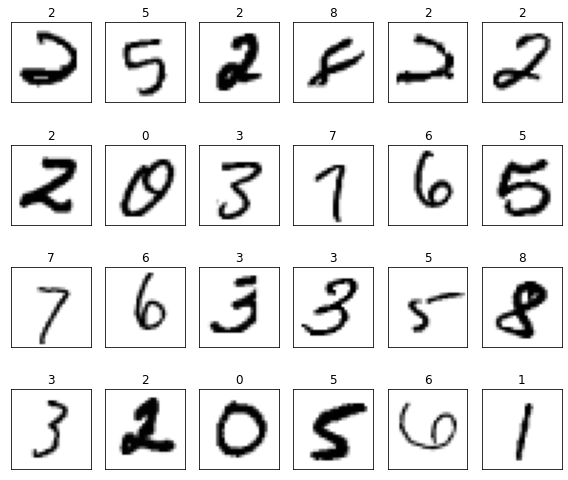

In [6]:
index = np.random.choice(np.arange(len(X_train)),24,replace=False)
fig,axes = plt.subplots(nrows=4,ncols=6,figsize=(8,8))
for item in zip(axes.ravel(),X_train[index],Y_train[index]):
    axes,image,target = item
    axes.imshow(image,cmap=plt.cm.gray_r)
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_title(target)
    plt.tight_layout()

In [32]:
print(f"X train shape - {X_train.shape}\nX test shape - {X_test.shape}")

X train shape - (60000, 28, 28)
X test shape - (10000, 28, 28)


In [33]:
# reshape danych w związku z tym, że Keras potrzebuje kształtu w postaci (Szerokość, wysokość, kanały) gdzie "kanały" to wartość 0-255 określającą odcień szarości
X_train = X_train.reshape((60000,28,28,1))
X_test = X_test.reshape((10000,28,28,1))


In [34]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [35]:
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

# CNN

In [36]:
from tensorflow.keras.models import Sequential

cnn = Sequential()

In [37]:
from tensorflow.keras.layers import Conv2D,Dense,Flatten,MaxPooling2D

# warstwa konwulcji
# 64 filtry, rozmiar jądra 3x3, aktywacja przez ReLU, inputem będą daane o kształcie 28,28,1
cnn.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu',input_shape=(28,28,1)))

# warstwa łącząca
# rozmiar pool'a 2x2
cnn.add(MaxPooling2D(pool_size=(2,2)))

# kolejna warstwa konwulcji
# 128 filtrów, rozmiar jądra 3x3, aktywacja przez relu
cnn.add(Conv2D(filters=128, kernel_size=(3,3),activation='relu'))

# kolejna warstwa łącząca
# rozmiar pool'a dalej 2x2
cnn.add(MaxPooling2D(pool_size=(2,2)))

# warstwa spłaszczająca
cnn.add(Flatten())

# warstwa gęsta
# 128 neuronów, funkcja aktywacji ReLU
cnn.add(Dense(units=128,activation='relu'))

# warstwa wyjściowa produkująca wynik (klasyfikacje 0-9), 10 neuronów bo 10 możliwych wyników liczb, funkcja aktywacji softmax (zwraca wartość o największej wartości probabilistycznej)
cnn.add(Dense(units=10,activation='softmax'))



In [38]:
# Podsumowanie modelu wraz z kształtem inputów na warstwie i parametrów
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               409728    
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

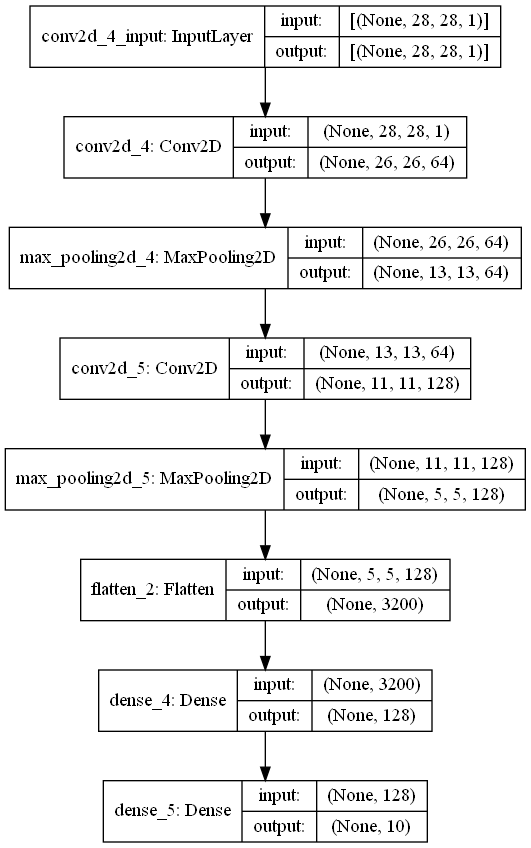

In [39]:
# Na zdjęciu widać zmianę wymiarowości począwszy od 28x28x1 aż do docelowych 10 outputów liczbowych
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(cnn,to_file="CNN.png",show_shapes=True,show_layer_names=True)
Image(filename="CNN.png")

In [40]:
# kompilacja modelu
# używamy optimizera adam, funkcję straty crossentropy która jest idealna dla multiklasyfikacji (jak u nas 10 możliwych wyników) i metryki accuracy, która określa % trafnych dopasowań w naszym modelu klasyfikacyjnym
cnn.compile(optimizer='adam',loss='kullback_leibler_divergence',metrics=['accuracy'])

In [41]:
# fit modelu naszymi danymi
# wybieramy 5/10 epok jako optymalną ilość kompletnych przetworzeń danych treningowych przez model
# wybieramy batch_size jako 32/64 (ilość próbek w batchu), czyli porcji przetwarzanej jednorazowo przez model w ramach 1 epoki. Po przetworzeniu każdego batchu, sieć aktualizuje parametry.
# wybieramy validation_split na 0.1 co oznacza, że z każdej epoki bierzemy 10% liczb w celu walidacji i wyświetleniu wyników walidacyjnych jak accuracy i loss

cnn.fit(X_train,Y_train,epochs=5,batch_size=64,validation_split=0.1)

# Końcowo lądujemy z ilością 1688 danych per epokę (60.000 danych w zbiorze treningowym / batch_size - 10% z tego dzielenia ze względu na użycie splitu walidacyjnego 0.1)
# Wyświetlają nam się dane jak loss i accuracy oszacowane przez model w każdej epoce i wyniki tych samych parametrów na zbiorze walidacyjnym 10%

Epoch 1/5
844/844 [==============================] - 24s 28ms/step - loss: 0.3440 - accuracy: 0.8937 - val_loss: 0.0465 - val_accuracy: 0.9867
Epoch 2/5
844/844 [==============================] - 23s 28ms/step - loss: 0.0446 - accuracy: 0.9855 - val_loss: 0.0345 - val_accuracy: 0.9900
Epoch 3/5
844/844 [==============================] - 23s 28ms/step - loss: 0.0304 - accuracy: 0.9907 - val_loss: 0.0381 - val_accuracy: 0.9892
Epoch 4/5
844/844 [==============================] - 23s 27ms/step - loss: 0.0214 - accuracy: 0.9924 - val_loss: 0.0418 - val_accuracy: 0.9878
Epoch 5/5
844/844 [==============================] - 23s 28ms/step - loss: 0.0133 - accuracy: 0.9955 - val_loss: 0.0310 - val_accuracy: 0.9905


In [42]:
# Wyświetlenie straty i accuracy na danych testowych
loss, accuracy = cnn.evaluate(X_test,Y_test)
print(f"Loss - {loss}\nAccuracy - {accuracy}")

313/313 [==============================] - 1s 5ms/step - loss: 0.0246 - accuracy: 0.9926
Loss - 0.02460918202996254
Accuracy - 0.9926000237464905


In [44]:
# wyszukiwanie chybionych prognoz
y_predict = cnn.predict(X_test)

pictures = X_test.reshape((10000,28,28))
wrong_predicted = []

for i, (p,e) in enumerate(zip(y_predict,Y_test)):
    predicted, right = np.argmax(p),np.argmax(e)

    if predicted != right:
        wrong_predicted.append((i,pictures[i],predicted,right))

In [45]:
# Liczba omylnych predykcji
len(wrong_predicted)

74

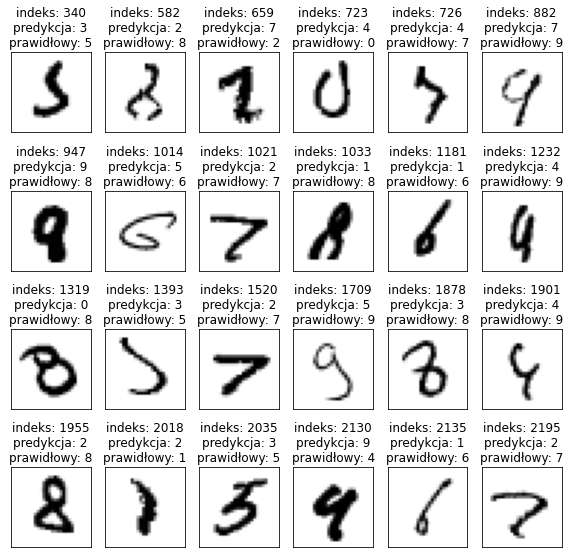

In [46]:
# Zobrazowanie pomyłek w plocie

fig,axes = plt.subplots(nrows=4,ncols=6,figsize=(8,8))
for axes, element in zip(axes.ravel(),wrong_predicted):
    index,image,predicted,right = element
    axes.imshow(image,cmap=plt.cm.gray_r)
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_title(f'indeks: {index}\npredykcja: {predicted}\nprawidłowy: {right}')
plt.tight_layout()

In [47]:
# GUI jako predykcja pisanej ręcznie liczby

import tensorflow as tf
from keras.models import load_model
import cv2
import numpy as np

classes=[0,1,2,3,4,5,6,7,8,9]

model=tf.keras.models.load_model('mnist_cnn.h5')
def testing():
    img=cv2.imread('image.png',0)
    img=cv2.bitwise_not(img)
##    cv2.imshow('img',img)
    img=cv2.resize(img,(28,28))
    img=img.reshape(1,28,28,1)
    img=img.astype('float32')
    img=img/255.0

    pred=cnn.predict(img)
    return pred


from PIL import ImageTk, Image, ImageDraw
import PIL
import tkinter as tk
from tkinter import *

classes=[0,1,2,3,4,5,6,7,8,9]
width = 500
height = 500
center = height//2
white = (255, 255, 255)
green = (0,128,0)

def paint(event):
    x1, y1 = (event.x - 10), (event.y - 10)
    x2, y2 = (event.x + 10), (event.y + 10)
    cv.create_oval(x1, y1, x2, y2, fill="black",width=20)
    draw.line([x1, y1, x2, y2],fill="black",width=40)
def model():
    filename = "image.png"
    image1.save(filename)
    pred=testing()
    txt.insert(tk.INSERT,"{}\nAccuracy: {}%".format(classes[np.argmax(pred[0])],round(pred[0][np.argmax(pred[0])]*100,3)))
    
def clear():
    cv.delete('all')
    draw.rectangle((0, 0, 500, 500), fill=(255, 255, 255, 0))
    txt.delete('1.0', END)

root = Tk()
##root.geometry('1000x500') 

root.resizable(0,0)
cv = Canvas(root, width=width, height=height, bg='white')
cv.pack()

# PIL create an empty image and draw object to draw on
# memory only, not visible
image1 = PIL.Image.new("RGB", (width, height), white)
draw = ImageDraw.Draw(image1)

txt=tk.Text(root,bd=3,exportselection=0,bg='WHITE',font='Helvetica',
            padx=10,pady=10,height=5,width=20)

cv.pack(expand=YES, fill=BOTH)
cv.bind("<B1-Motion>", paint)

##button=Button(text="save",command=save)
btnModel=Button(text="Predict",command=model)
btnClear=Button(text="clear",command=clear)
##button.pack()
btnModel.pack()
btnClear.pack()
txt.pack()
root.title('digit recognizer---- Shafin Hasnat')
root.mainloop()